In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from data.dataloader import dataloader
from GANs.generator import Generator
from GANs.discriminator import Discriminator
from GANs.methods import weight_init, training
from torchinfo import summary

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.9.1+cu128
True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
latent_dim = 100

noise_z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
train_loader, test_loader = dataloader('CIFAR10', batch_size=batch_size)

In [4]:
# from torchinfo import summary

generator = Generator(latent_dim=latent_dim, img_channels=3, bias=False)
discriminator = Discriminator(in_channels=3, bias=False)

# summary(generator, input_size=(batch_size, latent_dim, 1, 1))
# summary(discriminator, input_size=(batch_size, 3, 32, 32))

generator.apply(weight_init), discriminator.apply(weight_init)

(Generator(
   (generator): Sequential(
     (0): GenBlock(
       (conv): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
       (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
     )
     (1): GenBlock(
       (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
     )
     (2): GenBlock(
       (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
     )
     (3): GenBlock(
       (conv): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [15]:
summary(generator, input_size=(batch_size, latent_dim, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [64, 3, 32, 32]           --
├─Sequential: 1-1                        [64, 3, 32, 32]           --
│    └─GenBlock: 2-1                     [64, 512, 2, 2]           --
│    │    └─ConvTranspose2d: 3-1         [64, 512, 2, 2]           819,200
│    │    └─BatchNorm2d: 3-2             [64, 512, 2, 2]           1,024
│    │    └─ReLU: 3-3                    [64, 512, 2, 2]           --
│    └─GenBlock: 2-2                     [64, 256, 4, 4]           --
│    │    └─ConvTranspose2d: 3-4         [64, 256, 4, 4]           2,097,152
│    │    └─BatchNorm2d: 3-5             [64, 256, 4, 4]           512
│    │    └─ReLU: 3-6                    [64, 256, 4, 4]           --
│    └─GenBlock: 2-3                     [64, 128, 8, 8]           --
│    │    └─ConvTranspose2d: 3-7         [64, 128, 8, 8]           524,288
│    │    └─BatchNorm2d: 3-8             [64, 128, 8, 8]        

In [16]:
summary(discriminator, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [64]                      --
├─Sequential: 1-1                        [64, 1, 1, 1]             --
│    └─Conv2d: 2-1                       [64, 64, 16, 16]          3,072
│    └─LeakyReLU: 2-2                    [64, 64, 16, 16]          --
│    └─DiscBlock: 2-3                    [64, 128, 8, 8]           --
│    │    └─Conv2d: 3-1                  [64, 128, 8, 8]           131,072
│    │    └─InstanceNorm2d: 3-2          [64, 128, 8, 8]           256
│    │    └─LeakyReLU: 3-3               [64, 128, 8, 8]           --
│    └─DiscBlock: 2-4                    [64, 256, 4, 4]           --
│    │    └─Conv2d: 3-4                  [64, 256, 4, 4]           524,288
│    │    └─InstanceNorm2d: 3-5          [64, 256, 4, 4]           512
│    │    └─LeakyReLU: 3-6               [64, 256, 4, 4]           --
│    └─DiscBlock: 2-5                    [64, 512, 2, 2]           --


In [5]:
criterion = nn.BCEWithLogitsLoss()
optimizerG = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=5e-5, betas=(0.5, 0.999))  # if it breaks try 5e-5

training(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    epochs=70,
    optimizerG=optimizerG,
    optimizerD=optimizerD,
    criterion=criterion,
    device=device,
    use_amp=True
)

Training Progress: 100%|██████████| 70/70 [29:19<00:00, 25.14s/it, train_D_loss=0.00877, train_G_loss=0.00559]


tensor([[[[-1.2584e-02,  2.6927e-03,  2.3643e-02,  ...,  6.1282e-04,
            1.4796e-02,  4.5823e-03],
          [ 2.0792e-02,  4.2566e-02,  3.5988e-02,  ...,  2.7647e-02,
            2.2372e-02,  3.9050e-02],
          [ 4.1940e-02,  3.0207e-02,  6.3608e-02,  ...,  2.4973e-02,
            5.4311e-02,  1.1123e-02],
          ...,
          [-1.0451e-01, -9.2599e-02, -9.1226e-02,  ..., -9.1945e-02,
           -1.0521e-01, -1.2143e-01],
          [-7.8164e-02, -9.3524e-02, -7.5320e-02,  ..., -1.1648e-01,
           -1.0718e-01, -1.4441e-01],
          [-5.8651e-02, -6.2681e-02, -9.0179e-02,  ..., -1.3322e-01,
           -1.3234e-01, -8.3020e-02]],

         [[-5.1710e-02, -6.9073e-02, -6.4272e-02,  ..., -8.1823e-02,
           -7.5081e-02, -3.9866e-02],
          [-3.8077e-02, -5.9871e-02, -5.7174e-02,  ..., -8.7977e-02,
           -6.8647e-02, -4.1002e-02],
          [-1.9165e-02, -5.0799e-02, -4.7926e-02,  ..., -7.2290e-02,
           -5.9676e-02, -5.1345e-02],
          ...,
     

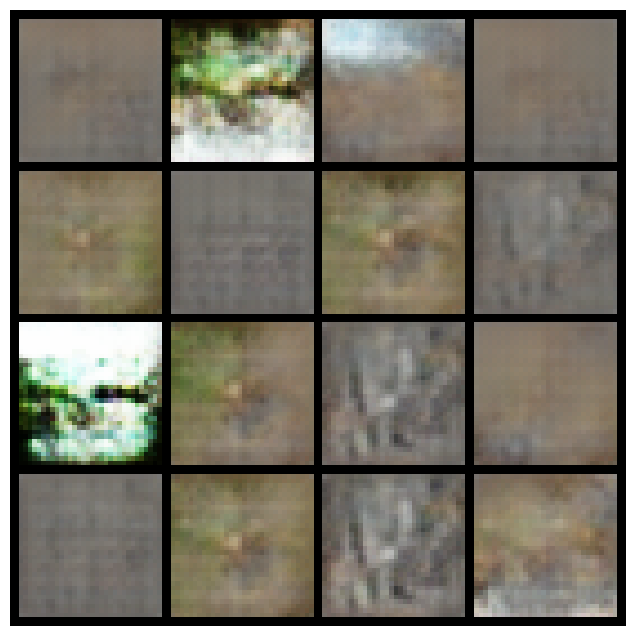

In [6]:
import matplotlib.pyplot as plt
import torchvision

example = torch.randn(16, latent_dim, 1, 1, device=device)
generator.eval()
with torch.no_grad():
    generator.to(device=device)
    generated_images = generator(example)
    print(generated_images, generated_images.shape)

grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()